# Description

In this notebook I scrap voting history of czech parlament from https://www.psp.cz/sqw/hlasovani.sqw?o=8. And use visualizations to draw some interesting facts from the scrapped data.


In [102]:
import requests as rq
from bs4 import BeautifulSoup
from time import sleep
import csv
from typing import *

In [103]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [104]:
base_url = 'https://www.psp.cz/sqw/hl.sqw?o=8&s=3'

In [105]:
response = rq.get(base_url)

scraps detailed descriptions of important vote topics from a separate page

In [106]:
def scrap_agendas(assemblies: List[int], filename: str) -> None:
    """
        This function collects all discussed topics and saves their description to a CSV file.
    """
    start_url = 'https://www.psp.cz/sqw/hl.sqw?o=8&s=%d'
    agendas = []
    for a in assemblies:
        response = rq.get(start_url % a) # all pages have the same format, so we dont't need to actually scrap them
        if response.ok:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            if not soup.find('div', id='main-content').find('a'): # Check if assembly number is valid
                print(f'Assembly {a} is not available') 
                # If url is invalid, instead of failing, website shows us a blank page
                continue
            
            for b in soup.find('div', id='main-content').find_all('b')[1:]: # Ignore the technical stuff
                no, _, desc = b.text.partition('.')
                agendas.append({'assembly_no': a, 'topic_no': int(no), 'description': desc})
        
        sleep(1) # Keeping it civil
        
    with open(filename, 'w', encoding='utf-8') as f:
        dw = csv.DictWriter(f, fieldnames=['assembly_no', 'topic_no', 'description'])
        dw.writeheader()
        dw.writerows(agendas)

In [107]:
def result_tables_links(assemblies: List[int], filename: str = '') -> List[str]:
    """
        Gets a list of links leading to each assemblies' results table, optioanlly saving it to file
    """
    start_url = 'https://www.psp.cz/sqw/hl.sqw?o=8&s=%d'
    base_url = 'https://www.psp.cz/sqw/'
    res_urls = []
    
    for a in assemblies:
        response = rq.get(start_url % a)
        if response.ok:
            soup = BeautifulSoup(response.text, 'lxml')
            l = soup.find('div', id='main-content').find('aa') # Find the first link, that will lead to the first page
            
            if l:
                res_urls.append(base_url + l['href'])

        sleep(1) # sleep between the requests
        
    if filename: # Save
        with open(filename, 'w') as f:
            f.writelines(res_urls)
    
    return res_urls

So, that's when I realized how unncecesary all of this was...

In [108]:
def result_tables() -> List[str]:
    base =  'https://www.psp.cz/sqw/phlasa.sqw?o=8&s=%d&pg=1'
    return [base % x for x in range(1, 62) if x != 10 and x != 21]

gets general info about each vote available from table with results

In [109]:
def parse_table_page(soup):
    results = []
    for row in soup.find('div', id='main-content').find_all('tr')[1:]:
        cols = row.find_all('td')
        topic_nums = ''.join([x for x in cols[2].text if x.isdigit()]) # there are weird characters mixed with the number
        topic_no = int(topic_nums) if topic_nums else 0
        link = cols[1].a['href']
        _, _, link = link.partition('g=')
        index, _, _ = link.partition("&l") # Getting vote id from the link
        results.append(
            {
                'vote_id': int(index),
                'assembly_no': cols[0].text,
                'topic_no': topic_no,
                'title': cols[3].text,
                'date': cols[4].text,
                'result': cols[5].text,
            }
        )
    return results

def parse_table(url: str):
    base_url = 'https://www.psp.cz/sqw/'
    response = rq.get(url)
    results = []
    soup = BeautifulSoup(response.text, 'lxml')
    results = parse_table_page(soup)

    while n := soup.find('a', class_='next'):
        sleep(1)
        response = rq.get(base_url + n['href'])
        soup = BeautifulSoup(response.text, 'lxml')
        results += parse_table_page(soup)
        
    return results



# parse_table('https://www.psp.cz/sqw/phlasa.sqw?o=8&s=2&pg=1')

In [110]:
def save_all_results(filename):
    with open(filename, 'w', encoding='utf-8') as f:
        dw = csv.DictWriter(f, fieldnames=['vote_id', 'assembly_no', 'topic_no', 'title', 'date', 'result'])
        dw.writeheader()
        for i, table in enumerate(result_tables()):
            print(f'Parsing table for assembly no {i}')
            dw.writerows(parse_table(table))
        
# save_all_results('all_results.csv')

parses overview table on votes page

In [111]:
def single_page_per_party(url, v):
    response = rq.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    
    if not (m := soup.find('div', id='main-content')):
        return [] # Results may not public yet
    
    rows = m.find('div', align='center').find_all('tr')
    results = []
    for row in rows[1:-1]:
        cols = row.find_all('td')
        results.append(
            {
                "vote_id": v,
                "party": cols[0].text,
                "total": int(cols[1].text),
                "yes": int(cols[2].text),
                "no": int(cols[3].text),
                "not_in": int(cols[4].text),
                "refrained": int(cols[5].text),
                "excused": int(cols[6].text)
            }
        )
    return results
            
def save_results_per_party(filename):
    start_url = 'https://www.psp.cz/sqw/hlasy.sqw?g=%d&l=cz'

    with open(filename, 'w', encoding='utf-8') as f:
        dw = csv.DictWriter(f, fieldnames=['vote_id', 'party', 'total', 'yes', 'no', 'not_in', 'refrained', 'excused'])
        dw.writeheader()
        for v in range(67018, 74003): # the most reasonable way to scrap for all pages
#         for v in range(67512, 67514):
            if v % 10 == 0:
                print(f'Parsing page no {v}')
            dw.writerows(single_page_per_party(start_url % v, v))
            sleep(1)

        
# save_results_per_party('per_party.csv')

Parses results per person for a single vote

In [112]:
def parse_single_votes_page(url, v):
    response = rq.get(url)
    results = []
    soup = BeautifulSoup(response.text, 'lxml')
    
    if not (m :=  soup.find('div', id='main-content')):
        return [] # Results may not public yet
    
    parties  = [p.span.text.split(" ")[0] for p in m.find_all('h2', class_='section-title')[1:-1]]
    vote_lists = m.find_all('ul', class_='results')
    
    for paty_name, votes in zip(parties, vote_lists):
        for vote in votes.find_all('li'):
            results.append(
                {
                    'vote_id': v,
                    'name': vote.a.text,
                    'party': paty_name, 
                    'decision': vote.span.text
                }
            )
    
    return results
        
        
def save_results_per_person(filename):
    start_url = 'https://www.psp.cz/sqw/hlasy.sqw?g=%d&l=cz'
    
    with open(filename, 'w', encoding='utf-8') as f:
        dw = csv.DictWriter(f, fieldnames=['vote_id', 'name', 'party', 'decision'])
        dw.writeheader()
        for v in range(67018, 74003):
            if v % 10 == 0:
                print(f'Page no {v}')
            dw.writerows(parse_single_votes_page(start_url % v, v))
            sleep(1)

            
# save_results_per_person('all_peopple.csv')

In [113]:
mdf = pd.read_csv("./all_peopple.csv")
mdf

,vote_id,name,party,decision
0,67018,Věra Adámková,ANO,A
1,67018,Andrej Babiš,ANO,A
2,67018,Andrea Babišová,ANO,A
3,67018,Margita Balaštíková,ANO,A
4,67018,Josef Bělica,ANO,A
...,...,...,...,...
1395995,74002,Tereza Hyťhová,Nezařaz,M
1395996,74002,Václav Klaus,Nezařaz,M
1395997,74002,Zuzana Majerová Zahradníková,Nezařaz,M
1395998,74002,Ivana Nevludová,Nezařaz,M


In [114]:
rdf = pd.read_csv("./all_results.csv")
rdf

,vote_id,assembly_no,topic_no,title,date,result
0,67018,1,3,Inf. o ustavení volební komise PS a volbě členů,20. 11. 2017 13:53,Přijato (zmatečné)
1,67019,1,3,Inf. o ustavení volební komise PS a volbě členů,20. 11. 2017 13:53,Přijato
2,67020,1,0,Procedurální hlasování,20. 11. 2017 14:47,Zamítnuto
3,67021,1,4,Náv.na stanovení počtu čl. MIV,20. 11. 2017 15:39,Zamítnuto
4,67022,1,4,Náv.na stanovení počtu čl. MIV,20. 11. 2017 15:39,Přijato
...,...,...,...,...,...,...
6978,73998,61,6,Novela z. o Vojenském zpravodajství (sněmovní ...,7. 10. 2020 17:54,Přijato
6979,73999,61,7,Novela z. - občanský soudní řád (sněmovní tisk...,7. 10. 2020 18:43,Přijato
6980,74000,61,7,Novela z. - občanský soudní řád (sněmovní tisk...,7. 10. 2020 18:44,Přijato
6981,74001,61,8,Novela z. o platu představitelů státní moci (s...,7. 10. 2020 19:23,Přijato


In [115]:
adf = pd.read_csv("./all_agendas.csv")
adf

,assembly_no,topic_no,description
0,1,3,Informace o ustavení volební komise Poslaneck...
1,1,4,Návrh na zřízení mandátového a imunitního výb...
2,1,6,Návrh na ustavení mandátového a imunitního vý...
3,1,7,Návrh na potvrzení předsedy mandátového a imu...
4,1,8,Informace mandátového a imunitního výboru o o...
...,...,...,...
1132,61,2,Návrh časového harmonogramu projednávání vlád...
1133,61,3,"Vládní návrh zákona, kterým se mění zákon č. ..."
1134,61,6,"Vládní návrh zákona, kterým se mění zákon č. ..."
1135,61,7,Návrh poslanců Kateřiny Valachové a Patrika N...


In [116]:
pdf = pd.read_csv("./all_per_party.csv")
pdf

,vote_id,party,total,yes,no,not_in,refrained,excused
0,67018,ANO,78,74,0,2,2,0
1,67018,ODS,25,24,0,1,0,0
2,67018,Piráti,22,22,0,0,0,0
3,67018,SPD,22,22,0,0,0,0
4,67018,ČSSD,15,13,0,0,2,0
...,...,...,...,...,...,...,...,...
67369,74002,KSČM,15,7,0,1,0,7
67370,74002,KDU-ČSL,10,3,0,0,0,7
67371,74002,TOP09,7,0,0,1,2,4
67372,74002,STAN,6,2,0,0,0,4


In [117]:
df = pd.merge(pdf, rdf, on='vote_id', how='inner')

# Party representation

## Mean party member counts 

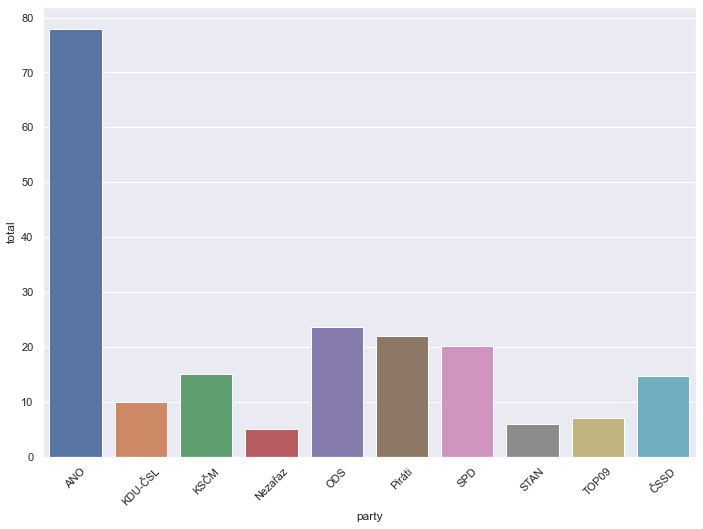

In [118]:
g = df[['party', 'total']].groupby(['party']).mean().reset_index()
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
b1 = sns.barplot(x='party', y='total', data=g)
_ = b1.set_xticklabels(b1.get_xticklabels(), rotation=45)
# g.set_index('party')

selecting one row from each of the assemblies

In [119]:
def one_of_each(col):
    tmp_set = set()
    each_unique =[]
    for a in col:
        if a not in tmp_set:
            tmp_set.add(a)
            each_unique.append(True)
        else:
            each_unique.append(False)
    return pd.Series(each_unique).values

apply new filter to all of the parties

In [120]:
all_parties = [] 
for p in df.party.unique():
    frame = df[df.party == p]
    filt = one_of_each(frame['assembly_no'])
    d = frame[filt][['party', 'assembly_no', 'total']]
    all_parties.append(d)

In [121]:
p_frame = pd.concat(all_parties)

## Member count per party at each assembly

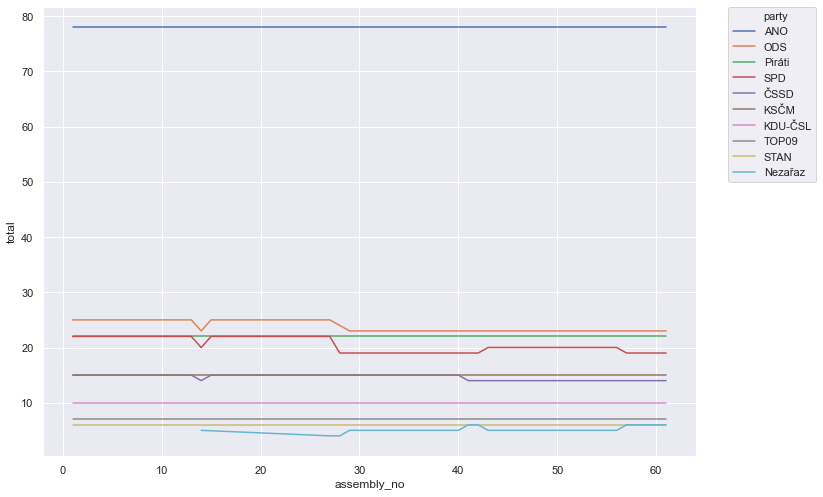

In [122]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x='assembly_no', y='total', hue='party', data=p_frame)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## The same, but without the ANO

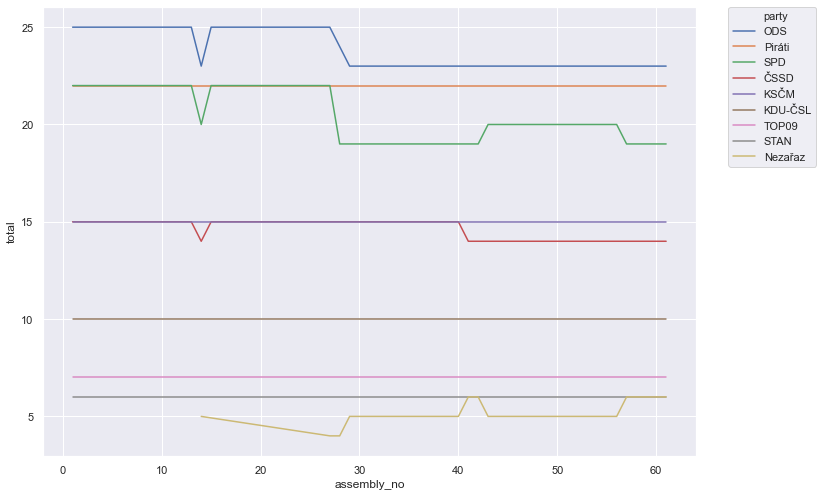

In [123]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x='assembly_no', y='total', hue='party', data=p_frame[p_frame.party != 'ANO'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Swithcing party

Find people, who switched

In [124]:
group = mdf.groupby('name')
mdf2 = group.apply(lambda x: x['party'].unique())
for l in filter(lambda x: len(x[1]) > 1, mdf2.iteritems()):
    print(l)

('Ivana\xa0Nevludová', array(['SPD', 'Nezařaz'], dtype=object))
('Jaroslav\xa0Foldyna', array(['ČSSD', 'Nezařaz', 'SPD'], dtype=object))
('Lubomír\xa0Volný', array(['SPD', 'Nezařaz'], dtype=object))
('Marian\xa0Bojko', array(['SPD', 'Nezařaz'], dtype=object))
('Tereza\xa0Hyťhová', array(['SPD', 'Nezařaz'], dtype=object))
('Václav\xa0Klaus', array(['ODS', 'Nezařaz'], dtype=object))
('Zuzana\xa0Majerová Zahradníková', array(['ODS', 'Nezařaz'], dtype=object))


Every one, who swithced their party did it once, moving from their party to Nezařaz, except for Jaroslav Foldyna, who has moved on to SPD afterwards.

(Checking, that party allegiances are in chronological order)

In [125]:
mdf[mdf.party.isin(['Nezařaz', 'SPD']) & (mdf.name == 'Jaroslav\xa0Foldyna')]

,vote_id,name,party,decision
1054595,72295,Jaroslav Foldyna,Nezařaz,0
1054795,72296,Jaroslav Foldyna,Nezařaz,0
1054995,72297,Jaroslav Foldyna,Nezařaz,A
1055195,72298,Jaroslav Foldyna,Nezařaz,N
1055395,72299,Jaroslav Foldyna,Nezařaz,A
...,...,...,...,...
1395125,73998,Jaroslav Foldyna,SPD,M
1395325,73999,Jaroslav Foldyna,SPD,M
1395525,74000,Jaroslav Foldyna,SPD,M
1395725,74001,Jaroslav Foldyna,SPD,M


forming something structured

In [126]:
group = mdf.groupby('name')
mdf2 = group.apply(lambda x: x['party'].unique())
switchers = {'name': [], 'from': [], 'to': []}
for l in filter(lambda x: len(x[1]) > 1, mdf2.iteritems()):
    for f, t in zip(l[1][:-1], l[1][1:]):
        switchers['name'].append(l[0])
        switchers['from'].append(f)
        switchers['to'].append(t)
        
switcher_df = pd.DataFrame.from_dict(switchers)
switcher_df

,name,from,to
0,Ivana Nevludová,SPD,Nezařaz
1,Jaroslav Foldyna,ČSSD,Nezařaz
2,Jaroslav Foldyna,Nezařaz,SPD
3,Lubomír Volný,SPD,Nezařaz
4,Marian Bojko,SPD,Nezařaz
5,Tereza Hyťhová,SPD,Nezařaz
6,Václav Klaus,ODS,Nezařaz
7,Zuzana Majerová Zahradníková,ODS,Nezařaz


### Amount of people, that leave a party for another one ... per party

In [127]:
fr = switcher_df['from'].value_counts()
fr

SPD        4
ODS        2
ČSSD       1
Nezařaz    1
Name: from, dtype: int64

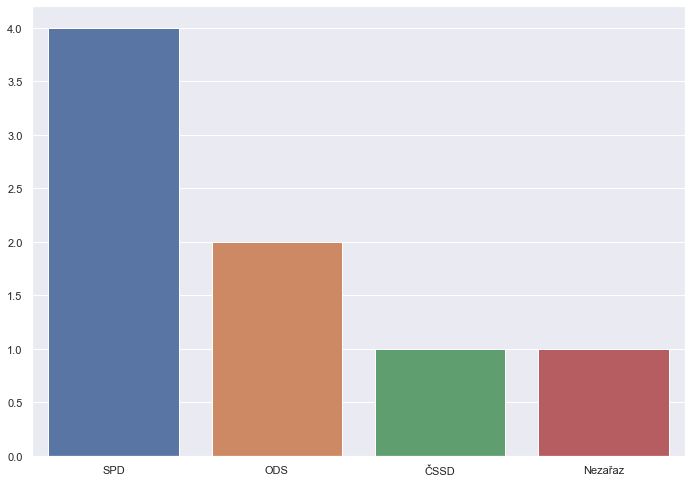

In [128]:
sns.barplot(fr.index, fr.values)

### Amount of people, that moved into each party from an already existing one

In [129]:
t = switcher_df['to'].value_counts()
t

Nezařaz    7
SPD        1
Name: to, dtype: int64

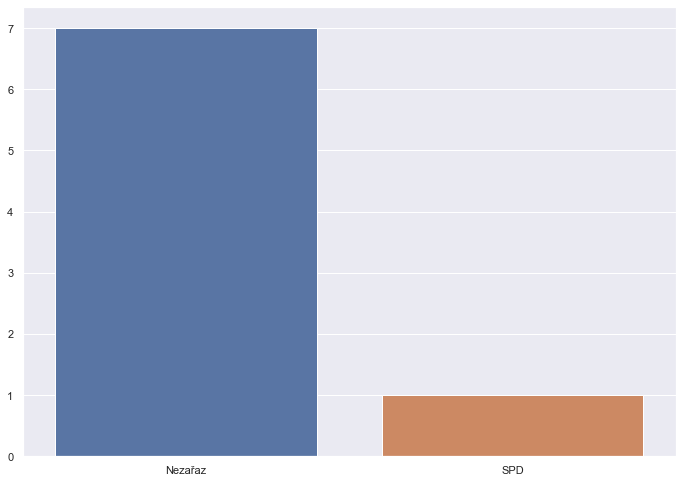

In [130]:
sns.barplot(t.index, t.values)

# Attendance

In [131]:
not_present_counts = mdf[mdf.decision.isin(['0', 'M'])].groupby(['name']).agg(['count'])['vote_id']
present_counts = mdf[~mdf.decision.isin(['0', 'M'])].groupby(['name']).agg(['count'])['vote_id']
not_present_counts.columns = ['missed']
present_counts.columns = ['visited']

In [132]:
att_df = pd.concat([not_present_counts, present_counts], axis=1)

Fin atttendance in percents

In [133]:
att_df['attendance'] = att_df['visited'] / (att_df['missed'] + att_df['visited'])

Fix NaNs for those, who hasn't missed a vote yet.

In [134]:
att_df.loc[np.isnan(att_df['attendance']), 'attendance'] = 1

In [135]:
att_df =  att_df.sort_values('attendance', ascending=False)

## Overall attendance per person in %

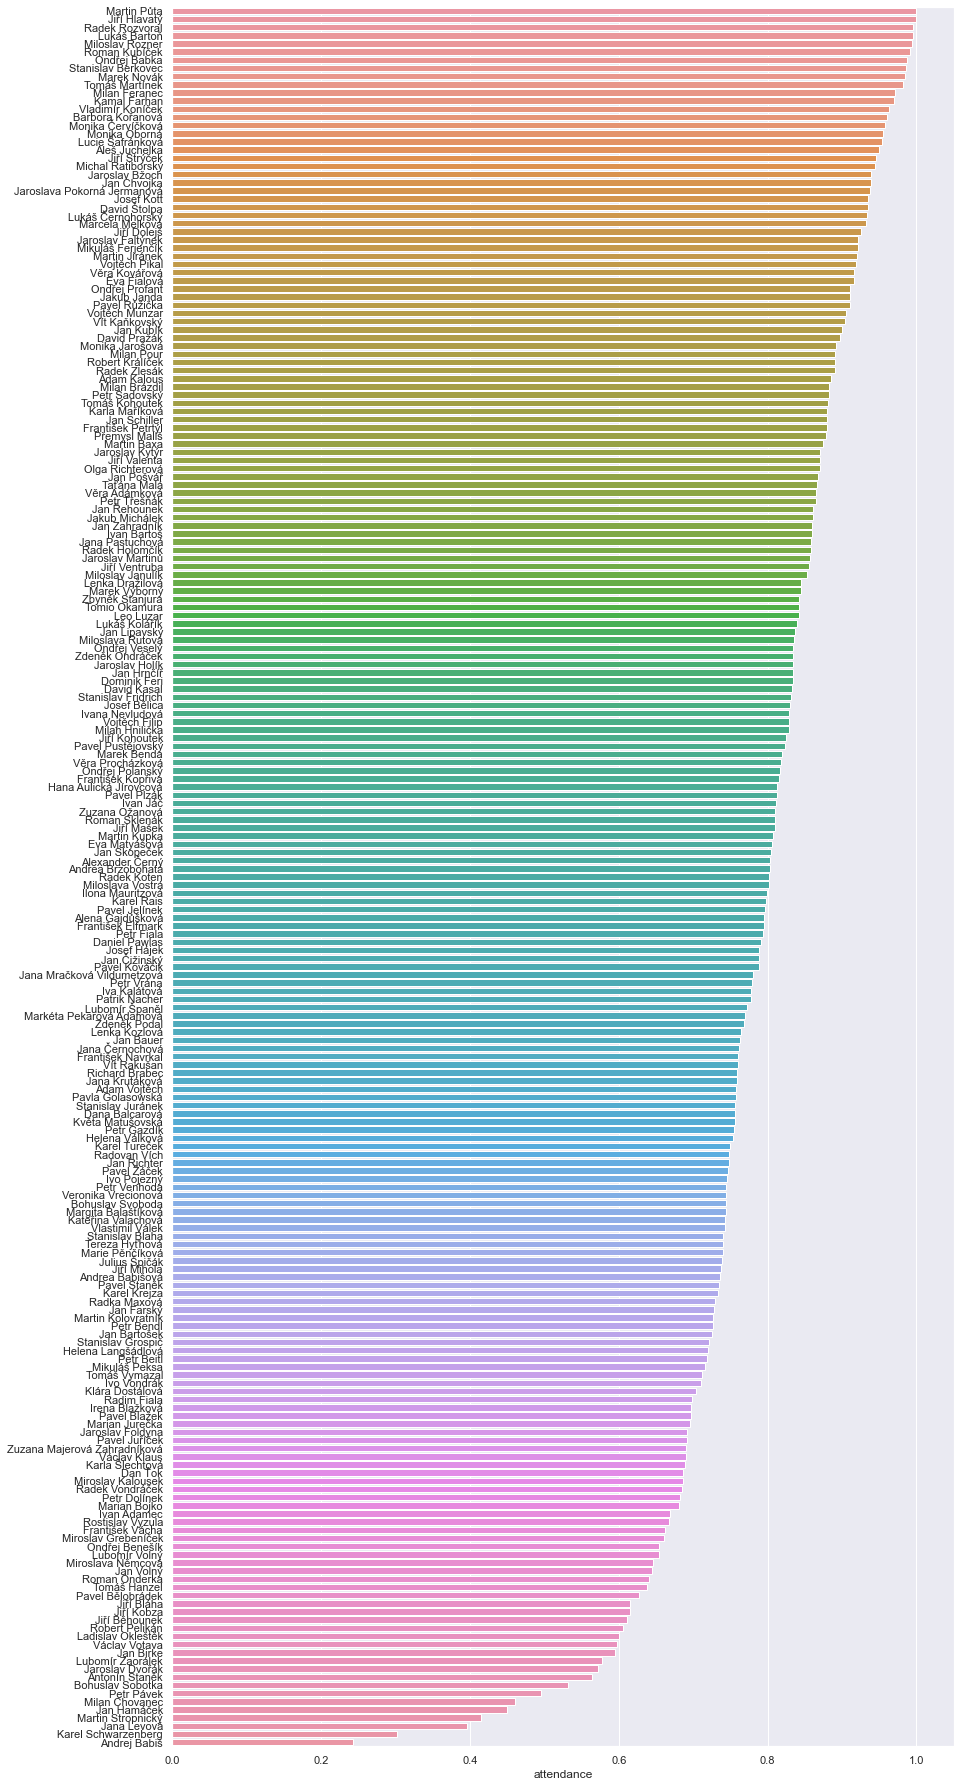

In [136]:
sns.set(rc={'figure.figsize':(14, 32)})
sns.barplot(y=att_df.index, x=att_df.attendance)
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Attendance of parties as a whole

Create a column, thracking the attendance.

In [137]:
pdf['attendance'] = (pdf['yes'] + pdf['no'] + pdf['refrained']) / pdf['total']

Count the mean.

In [138]:
avg_att = pdf[['party', 'attendance']].groupby('party').mean()
avg_att

,attendance
party,
ANO,0.823944
KDU-ČSL,0.749126
KSČM,0.797947
Nezařaz,0.653056
ODS,0.784459
Piráti,0.856226
SPD,0.786393
STAN,0.735649
TOP09,0.673578


Plot another bar chart

### Average party attendance

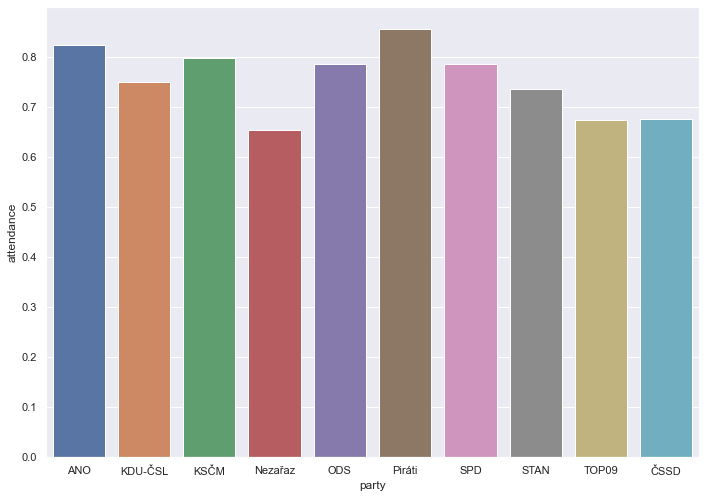

In [139]:
sns.barplot(x=avg_att.index, y=avg_att.attendance)

## Party Attendance over time

In [140]:
df['attendance'] = (df['yes'] + df['no'] + df['refrained']) / df['total']

In [141]:
df['date_no_time'] =  pd.Series([val.split(' ')[0] for val in df['date']])

In [142]:
df['present'] = df.total - df.not_in - df.excused

In [143]:
dfbp = df[['party', 'date_no_time', 'present', 'attendance']].groupby('party')

In [144]:
avg_df = df[['party', 'date_no_time', 'present', 'attendance']].groupby(['date_no_time', 'party'])['attendance'].mean().unstack('party')

In [145]:
avg_df = avg_df.reset_index()

### Average attendance per day for each of the parties

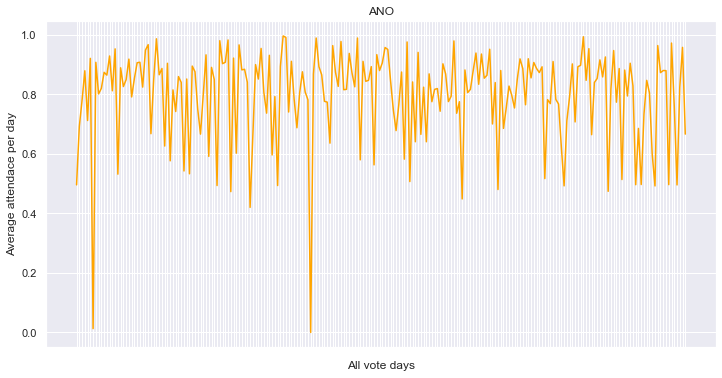

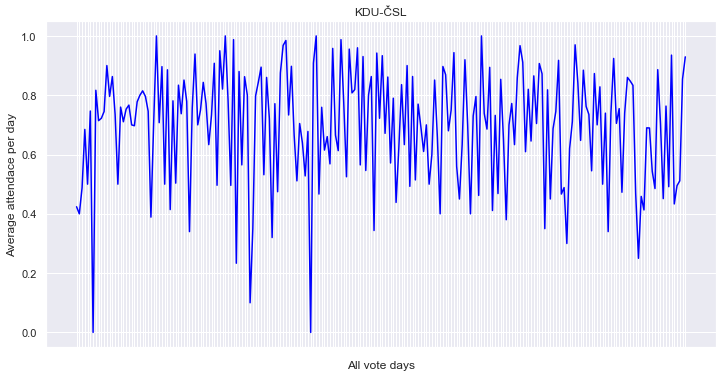

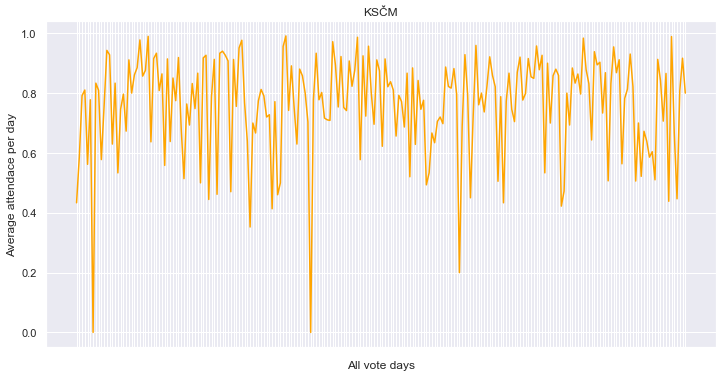

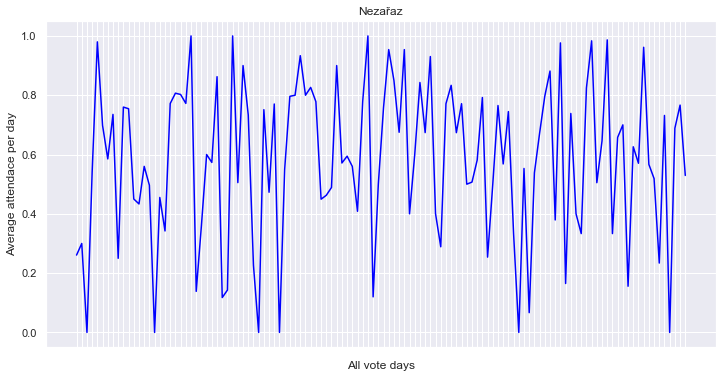

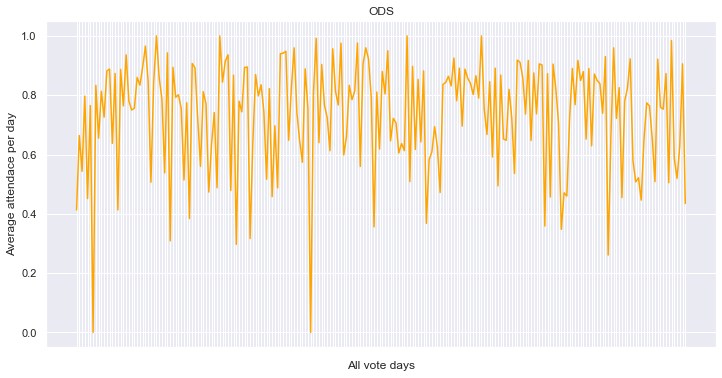

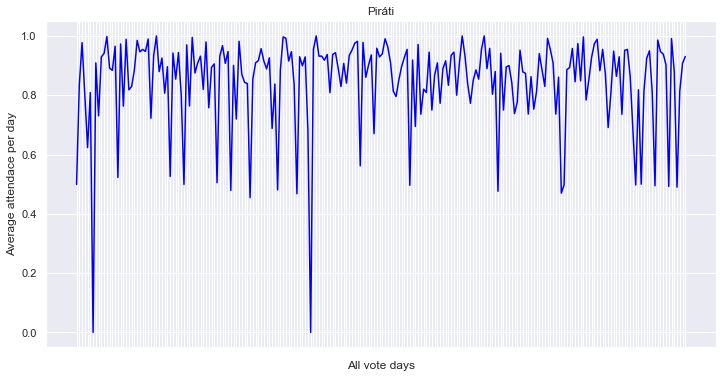

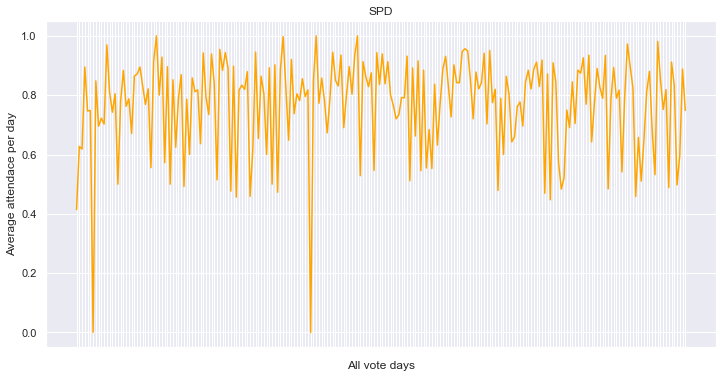

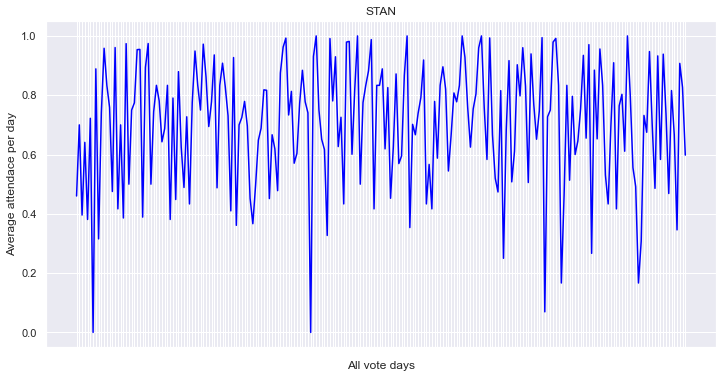

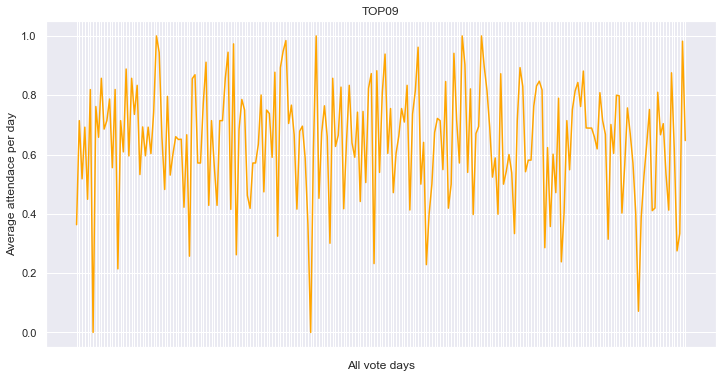

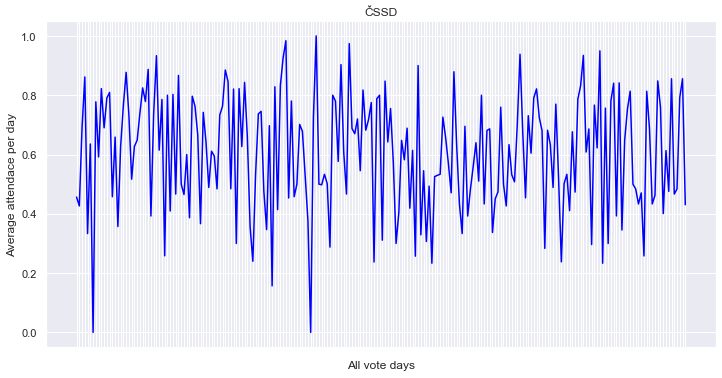

In [146]:
sns.set(rc={'figure.figsize':(12, 6)})
i = 0
for p in avg_df.columns[1:]:
    plt.figure(i)
    g = sns.lineplot(data=avg_df, x='date_no_time', y=p, color='orange' if i % 2 == 0 else 'blue')
    g.set(xticklabels=[])
    g.set(xlabel='All vote days')
    g.set(ylabel='Average attendace per day')
    g.set(title=p)
    i += 1
    
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Vote similarity

How similar are decisions of each parties' majorities

In [147]:
pdf['general_sentiment'] = np.where(pdf['yes'] > pdf['no'], 1, -1)
pdf['general_sentiment'] = np.where(np.maximum(pdf['yes'], pdf['no']) > pdf['refrained'], pdf['general_sentiment'], 0)

In [148]:
pdf

,vote_id,party,total,yes,no,not_in,refrained,excused,attendance,general_sentiment
0,67018,ANO,78,74,0,2,2,0,0.974359,1
1,67018,ODS,25,24,0,1,0,0,0.960000,1
2,67018,Piráti,22,22,0,0,0,0,1.000000,1
3,67018,SPD,22,22,0,0,0,0,1.000000,1
4,67018,ČSSD,15,13,0,0,2,0,1.000000,1
...,...,...,...,...,...,...,...,...,...,...
67369,74002,KSČM,15,7,0,1,0,7,0.466667,1
67370,74002,KDU-ČSL,10,3,0,0,0,7,0.300000,1
67371,74002,TOP09,7,0,0,1,2,4,0.285714,0
67372,74002,STAN,6,2,0,0,0,4,0.333333,1


In [149]:
from itertools import product
ps = pdf.party.unique()
pairs = [' '.join(pair) for pair in product(ps, ps)]

Count matching sentiments

In [150]:
similarities = {}
for p in pairs:
    similarities[p] = 0

# Not, the most elegant solution, but I need to run it only once   
for k, v in pdf[['vote_id','party','general_sentiment']].groupby('vote_id'):
    for _, p in v.iterrows():
        for _, o,in v.iterrows():
            if p['general_sentiment'] == o['general_sentiment']:
                at = p['party'] + " " + o['party']
                similarities[at] += 1
            

        
    

get percentages

In [151]:
len(pd.merge(pdf[pdf.party == "ANO"].vote_id, pdf[pdf.party == "Nezařaz"].vote_id, how='inner'))


4554

In [152]:
similarity_perc = {}
for k, v in similarities.items():
    p1, p2 = k.split(' ')
    # We have to divide by the count of meeting, where both parties were present.
    common_meetings = len(pd.merge(pdf[pdf.party == p1].vote_id, pdf[pdf.party == p2].vote_id, how='inner'))
    similarity_perc[k] = v / common_meetings 
    

remove duplicates

In [153]:
from itertools import combinations

uniq = [' '.join(pair) for pair in combinations(ps, 2)]
uniq_similarity_perc = { k: similarity_perc[k] for k in uniq}

In [154]:
sim_s = pd.Series(uniq_similarity_perc)

In [155]:
sim_s = sim_s.sort_values(ascending=False)

## Overall party similarities

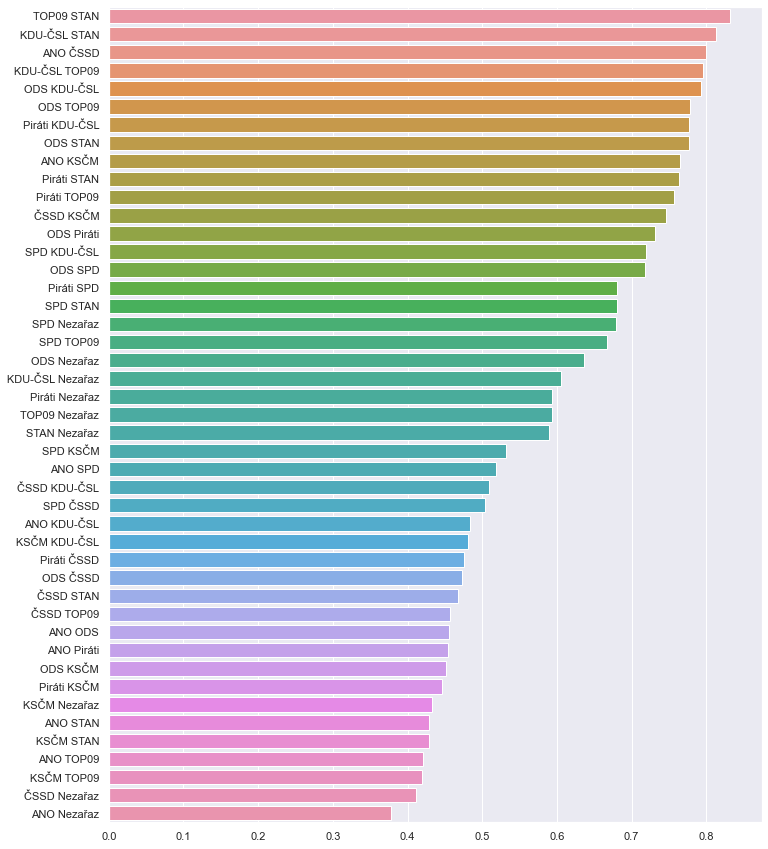

In [156]:
sns.set(rc={'figure.figsize':(11.7,15)})
sns.barplot(x=sim_s.values, y=sim_s.index)
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Same but with a fancy heatmap

(They look cool, but I somehow struggle to read them)

In [157]:
similarity_perc_df = pd.DataFrame(0, index=pdf.party.unique(), columns=pdf.party.unique(), dtype='float64')
for k, v in similarity_perc.items():
    p1, p2 = k.split(' ')
    similarity_perc_df.loc[p1][p2] = v

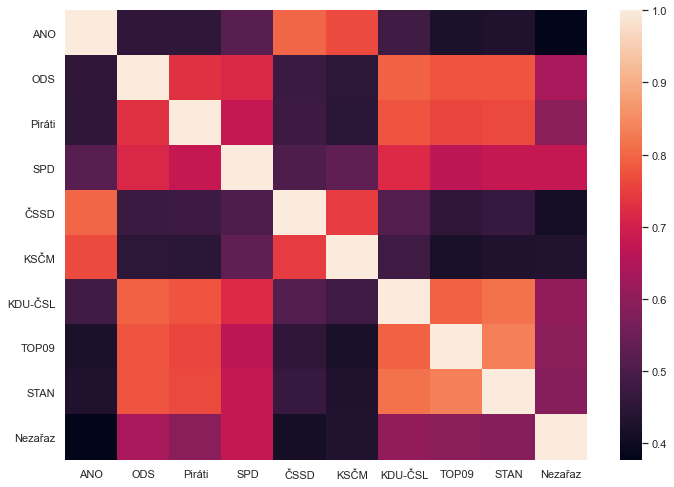

In [158]:
sns.heatmap(similarity_perc_df)

## Relative party unity 

Since actually comparing cartesian products of each vote for each person will take an eternity, I will try to count votes, that are different from the majority, to quantify second thoughts in the party. Therefore the highrer the nummber, the less unity in the party.

In column rebels I store the amount of people, that disagreed with the party's majority, normalized by the total count of members.

In [159]:
pdf['rebels'] = (pdf.total - pdf[['yes', 'no', 'refrained']].max(axis=1) - pdf.excused - pdf.not_in) / pdf.total

In [160]:
mean_rpu = pdf.groupby('party')['rebels'].mean()
mean_rpu

party
ANO        0.073294
KDU-ČSL    0.059914
KSČM       0.114346
Nezařaz    0.103663
ODS        0.052184
Piráti     0.050742
SPD        0.028634
STAN       0.069747
TOP09      0.059190
ČSSD       0.131830
Name: rebels, dtype: float64

#### Average percentage of deputies, that vote differently to the party's majority, normalized by the total size of the party

`Differently` includes people refrained from the vote, but not those, who weren't present there

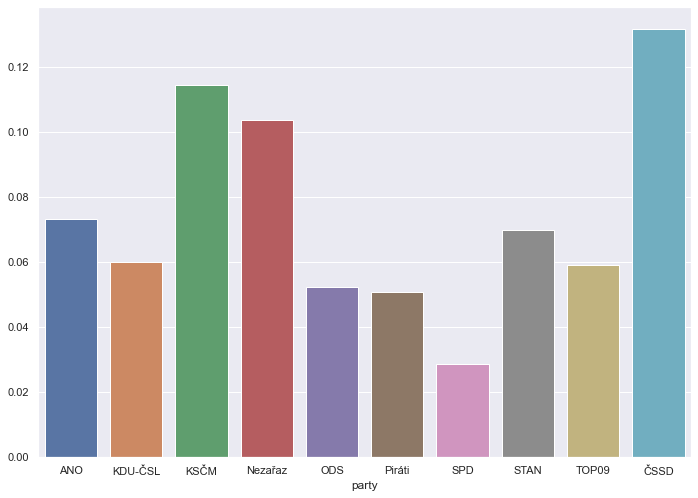

In [161]:
sns.barplot(x=mean_rpu.index, y=mean_rpu.values)

## Party members vs. Party

How often and who disagrees with their party's mainstream.

use the same format

In [162]:
pdf['general_sentiment'] = np.where(pdf['yes'] > pdf['no'], 'A', 'N')
pdf['general_sentiment'] = np.where(np.maximum(pdf['yes'], pdf['no']) > pdf['refrained'], pdf['general_sentiment'], 'N')

In [163]:
mdf

,vote_id,name,party,decision
0,67018,Věra Adámková,ANO,A
1,67018,Andrej Babiš,ANO,A
2,67018,Andrea Babišová,ANO,A
3,67018,Margita Balaštíková,ANO,A
4,67018,Josef Bělica,ANO,A
...,...,...,...,...
1395995,74002,Tereza Hyťhová,Nezařaz,M
1395996,74002,Václav Klaus,Nezařaz,M
1395997,74002,Zuzana Majerová Zahradníková,Nezařaz,M
1395998,74002,Ivana Nevludová,Nezařaz,M


In [164]:
ppdf = pd.merge(mdf, pdf, how='inner', left_on=['vote_id', 'party'], right_on=['vote_id', 'party'])

In [165]:
ppdf

,vote_id,name,party,decision,total,yes,no,not_in,refrained,excused,attendance,general_sentiment,rebels
0,67018,Věra Adámková,ANO,A,78,74,0,2,2,0,0.974359,A,0.025641
1,67018,Andrej Babiš,ANO,A,78,74,0,2,2,0,0.974359,A,0.025641
2,67018,Andrea Babišová,ANO,A,78,74,0,2,2,0,0.974359,A,0.025641
3,67018,Margita Balaštíková,ANO,A,78,74,0,2,2,0,0.974359,A,0.025641
4,67018,Josef Bělica,ANO,A,78,74,0,2,2,0,0.974359,A,0.025641
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395995,74002,Tereza Hyťhová,Nezařaz,M,6,0,0,0,0,6,0.000000,N,0.000000
1395996,74002,Václav Klaus,Nezařaz,M,6,0,0,0,0,6,0.000000,N,0.000000
1395997,74002,Zuzana Majerová Zahradníková,Nezařaz,M,6,0,0,0,0,6,0.000000,N,0.000000
1395998,74002,Ivana Nevludová,Nezařaz,M,6,0,0,0,0,6,0.000000,N,0.000000


In [166]:
cats = ['{0[0]}{0[1]}'.format(tup) for tup in product(['A', 'N', 'Z'], ['A', 'N', 'Z'])]
tmp = []
ppdf_n = ppdf[ppdf.decision.isin(['A', 'N', "Z"])].groupby('name')

for name, data in ppdf_n:
    tmp.append(pd.Categorical((data.decision + data.general_sentiment), categories=cats).value_counts())
    

the first letter is the person's decision and party's is the second one

In [167]:
pvp = pd.concat(tmp, axis=1, keys=[m for m, _ in ppdf_n]).transpose().rename(columns=str).reset_index()
# Getting rid of categories
pvp.columns = ['name', 'AA', 'AN', 'AZ', 'NA', 'NN', 'NZ', 'ZA', 'ZN', 'ZZ']
pvp

,name,AA,AN,AZ,NA,NN,NZ,ZA,ZN,ZZ
0,Adam Kalous,2731,87,0,13,2027,0,232,1092,0
1,Adam Vojtěch,2190,17,0,8,1816,0,252,1008,0
2,Alena Gajdůšková,2467,158,0,14,1410,0,207,1298,0
3,Alexander Černý,2588,80,0,2,1386,0,157,1396,0
4,Aleš Juchelka,3100,63,0,11,1991,0,162,1297,0
...,...,...,...,...,...,...,...,...,...,...
208,Zbyněk Stanjura,4098,38,0,4,532,0,460,747,0
209,Zdeněk Ondráček,2526,146,0,11,1581,0,277,1280,0
210,Zdeněk Podal,3836,20,0,8,429,0,161,910,0
211,Zuzana Majerová Zahradníková,2963,164,0,17,373,0,365,940,0


In [168]:
pvp['cons_ratio'] = (pvp.AA + pvp.NN + pvp.ZZ) / (pvp.AA + pvp.AN + pvp.AZ + pvp.NA + pvp.NN + pvp.NZ + pvp.ZA + pvp.ZN + pvp.ZZ)
pvp['total_matches'] = (pvp.AA + pvp.NN + pvp.ZZ)
pvp['total_votes'] = (pvp.AA + pvp.AN + pvp.AZ + pvp.NA + pvp.NN + pvp.NZ + pvp.ZA + pvp.ZN + pvp.ZZ)

In [169]:
pvp = pvp.sort_values('cons_ratio')

## Overall similarity in votes between each person and their party

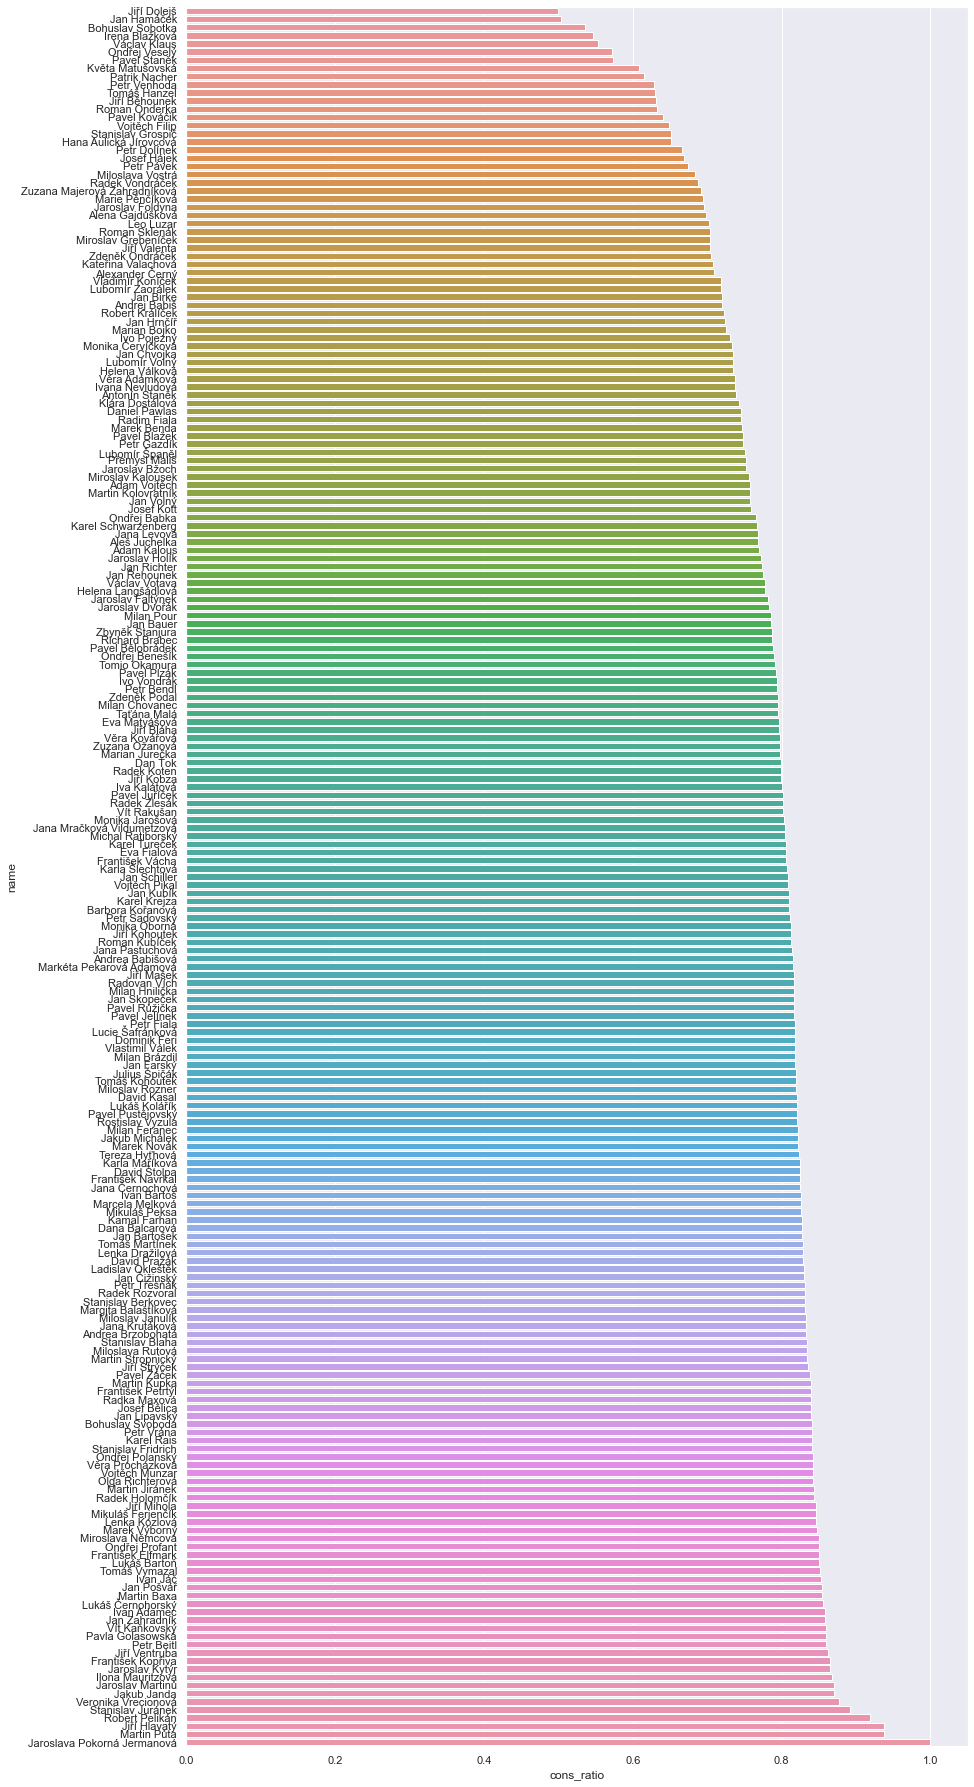

In [170]:
sns.set(rc={'figure.figsize':(14, 32)})
sns.barplot(x='cons_ratio',y='name', data=pvp)
sns.set(rc={'figure.figsize':(14, 8)})

## The same, but only the people, who voted at least 100 times

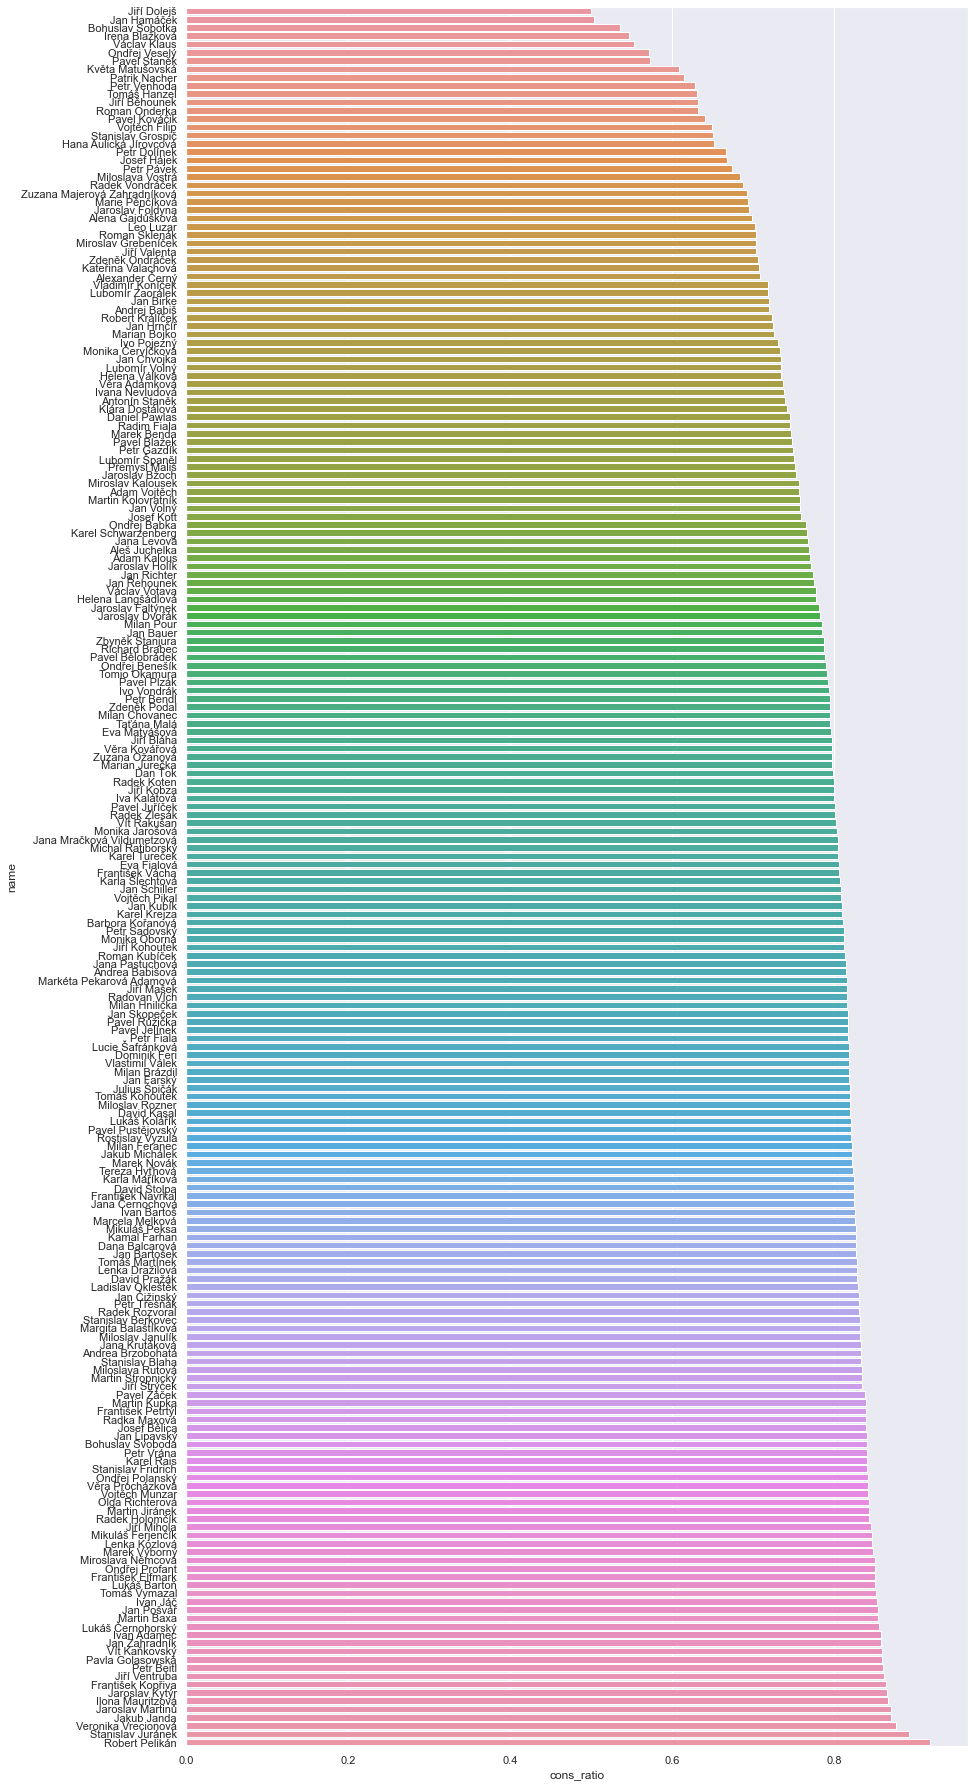

In [171]:
sns.set(rc={'figure.figsize':(14, 32)})
sns.barplot(x='cons_ratio',y='name', data=pvp[pvp.total_votes > 100])
sns.set(rc={'figure.figsize':(14, 8)})

#### The rebel

In [172]:
mdf[mdf.name == pvp.iloc[0]['name']]

,vote_id,name,party,decision
164,67018,Jiří Dolejš,KSČM,M
364,67019,Jiří Dolejš,KSČM,M
564,67020,Jiří Dolejš,KSČM,M
764,67021,Jiří Dolejš,KSČM,M
964,67022,Jiří Dolejš,KSČM,M
...,...,...,...,...
1395158,73998,Jiří Dolejš,KSČM,Z
1395358,73999,Jiří Dolejš,KSČM,A
1395558,74000,Jiří Dolejš,KSČM,A
1395758,74001,Jiří Dolejš,KSČM,A


#### The most ageeable person

In [173]:
mdf[mdf.name == pvp[pvp.total_votes > 100].iloc[-1]['name']]

,vote_id,name,party,decision
47,67018,Robert Pelikán,ANO,A
247,67019,Robert Pelikán,ANO,A
447,67020,Robert Pelikán,ANO,N
647,67021,Robert Pelikán,ANO,N
847,67022,Robert Pelikán,ANO,A
...,...,...,...,...
174447,67891,Robert Pelikán,ANO,N
174647,67892,Robert Pelikán,ANO,A
174847,67893,Robert Pelikán,ANO,A
175047,67894,Robert Pelikán,ANO,M
